# Counterfactual Fairness Replication
### By Potluri, Kai, Mingfei, and Ollie
#### Original Paper: Counterfactual Fairness by Kusner, Loftus, Russell, and Silva 

(https://arxiv.org/abs/1703.06856)


There are many machine learning algorithms that can and do automate decisions for complex issues such as receiving a loan, insurance pricing, predictive policing, prison sentences, etc. This  paper, by Kusner, Loftus, Russell, and Silva, seeks to develop a way to address whether a prediction is fair using tools from causal inference. Through causal modeling we can see how and where this unfairness is happening. Because algorithms use observed data to make predictions, data that may contain historical bias, (ex. racially biased police stop and frisk policies sexist/racist/ageist hiring policies) they can often result in unfair policy decisions. 

To understand how to evaluate fairness we must define what it means. Below are a definitions presented by the authors: 

- **Fairness through unawareness** – an algorithm does not use any protected attributes. If we have observations of a person’s race or sex we just ignore that information

- **Individual Fairness** – an algorithm gives similar predictions to similar individuals

- **Demographic Parity** – an algorithm gives the same prediction no matter what the value of the given predictor is

- **Equality of Opportunity** – an algorithm gives the same prediction given the outcome regardless of the protected attribute

- **Counterfactual Fairness** – Had any individual been of a different race, sex, etc. the prediction would not change

The authors believe that counterfactual fairness is the correct definition to use because we can make comparisons on an individual level. We are asking what would have happened if this same person was of a different race or sex.

Below is a simple example from the paper to show how counterfactual awareness works. We are looking to predict the accident rate of an individual given we have observations on some protected attribute and the color of their car. See below for the complete model.

- **A Protected Attribute** - any attribute that should not be discriminated 
- **X Observable attribute** – Red Car
- **Y outcome of interest** – Accident Rate
- **U latent variable** – Aggressive Driving


![image alt ><](project_DAG_2.png)

In this example, some group A is more likely than other groups to drive a red car but are not more likely to get into an accident. However, people who are more likely to be aggressive drivers like to drive red cars as well. We are explicitly modeling a discriminatory effect as a causal effect. If we were to predict who would have a high accident rate Y by using just X we would have a counterfactually unfair prediction because we know that individuals of the protected attribute like to drive red cars more than other groups even though they don’t get into more accidents.

One of the main implications of counterfactual fairness is that a prediction will be counterfactually fair if it is a function of the non-descendants of A. In the example above we could not use the observable attribute red car to make a counterfactually fair prediction as any change in A would cause a change in the observed variable, red car. Instead we would want to try to infer the latent variable U.

This is not an if and only if statement however, it is possible for a prediction to be counterfactually fair if it is a function of a descendent of the protected attribute A. However, this is only true though if the dependence of the prediction on the protected attribute disappears in the function.

Another benefit of using causal inference to evaluate fairness is the ability to deal with historical bias. An example of this given in the paper is of whether a person defaults on a loan. A protected attribute may cause a person to default on a loan, but only through some past discrimination. The protected attribute for example may be mediated by employment which in turn is caused by the latent variable, prejudice. Prejudice could mean that the hiring process was unfair towards certain groups. This causes a person to be less likely to be employed and in turn increases the likelihood of default. Hence Y, a descendent of A, has historical discrimination and should not be used in the prediction of $\hat{Y}$.

We want to use variables that are not caused by A, the protected attribute, but are predictive of Y. Below is the algorithm given in the text.

### Fair Learning Algorithm

![](FairLearning Algorithm.png)

Essentially what the algorithm is saying is, given the observed values of A and X, extract the values of the latent variable U and then use those values in the predictive model. 

There are three different levels of assumptions that make counterfactual fairness possible. The higher levels (3 being the highest) require stronger assumptions

- Level 1 – Determine $\hat{Y}$ from observable non-descendents of A
- Level 2 – Determine $\hat{Y}$ through some non-deterministic latent variable 
- Level 3 – Determine $\hat{Y}$ through some deterministic latent variables (not discussed in great detail) 

The authors recommend always modeling the causal structure to reach the goal of counterfactual fairness. They state, “we are essentially learning a projection of T into the space of fair decisions, removing historical biases as a by-product ”. (p. 5) Modeling in this way does not always give the most accurate predictions, however this is not the goal of the procedure. The goal is to accurately model the real world including social bias's that may arise and to use causal modeling tools to address algorithmic unfariness. The following is another example of this in practice.

## **Law School Success** 

![](project_dag.png)

We have considered the example of law school success to implement the algorithms discussed
in the paper. In this example, the law school wants candidates with good knowledge to succeed
in the law program. However, knowledge is an unobserved variable. The challenge was to make
sure the admissions process was fair to underprivileged groups. The college admissions panel
doesn't use candidates' racial or gender identity in determining whether to admit them into the
program or not. They'd only consider the undergraduate GPA and LSAT score to keep the
process fair. However, the admissions panel's decision might get indirectly influenced by
protected attributes like race and sex. Students from less privileged backgrounds may lack the
economic opportunity to enroll in LSAT preparation courses. The classroom performance may
not depend on knowledge alone but also be unduly affected by sensitive attributes that we do
not want to use as a basis for admissions. In this project, we implemented concepts like fairness
through unawareness and counterfactual fairness as discussed in the paper. We leveraged
these concepts to identify historical bias while estimating knowledge. We built a structural
causal model using the above DAG to generate samples. These samples are used in the
Unaware and Full Model.

### The Model

We have constructed the SCM in Pyro using the above DAG. The probability assignments for
the simulation are made up as there was no simulation specific information in the paper. Race,
sex, and knowledge are considered exogenous variables. A probability of 0.75 and 0.5 are
assigned for Race and Sex respectively. The knowledge is drawn from a standard normal
distribution. Below you can find the equations that we have used to generate the synthetic data:
We have generated 1000 samples from this SCM to use in the implemented models.

In [105]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from torch import nn
import seaborn as sns
from pyro.nn import PyroModule

In [106]:
def GroundTruthModel():
    exo_dist = {
        'Nr': dist.Bernoulli(torch.tensor(0.75)),
        'Ns': dist.Bernoulli(torch.tensor(0.5)),
        'Nk': dist.Normal(torch.tensor(0.), torch.tensor(1.))
    }
    # sample from bernoulli 0 or 1, 0 at 75% freq (made up)
    R = pyro.sample("R", exo_dist['Nr'])
    S = pyro.sample("S", exo_dist['Ns'])
    
    # random gaussian dist for knowledge. This is the latent variable
    K = pyro.sample("K", exo_dist['Nk'])
    
    # PsuedoDelta 
    G = pyro.sample("G", dist.Normal(K + 4.0 * R + 1.5 * S, 0.1))
    
    L = pyro.sample("L", dist.Normal(K + 6.0*R + 0.5*S, 0.1))
    
    F = pyro.sample("F", dist.Normal(K + 3.0*R + 2.0*S, 0.1))

trace_handler = pyro.poutine.trace(GroundTruthModel)
samples = pd.DataFrame(columns=['R', 'S', 'K', 'G', 'L', 'F', 'p'])

## Unaware Model

An algorithm is fair so long as any protected attributes, in our example, Race and Sex, are not
explicitly used in the decision-making process. However, it has a clear shortcoming as elements
of X can contain discriminatory information analogous to protected attributes that may not be
obvious at first. To replicate this model, we have considered only the attributes GPA and LSAT.
This is the same model used initially by the law school assuming a fair admission policy. The
First year average(F) is predicted using the GPA(G) and LSAT(L). From the DAG, we can
understand that it is indirectly biased because of the Race(R) and Sex(S) and hence also
affecting the First year average(F).

In [107]:
unaware_sample= []
for i in range(1000):
    trace = trace_handler.get_trace()
    R = trace.nodes['R']['value']
    S = trace.nodes['S']['value']
    K = trace.nodes['K']['value']
    G = trace.nodes['G']['value']
    L = trace.nodes['L']['value']
    F = trace.nodes['F']['value']
    # get prob of each combination
    log_prob = trace.log_prob_sum()
    p = np.exp(log_prob)
    samples = samples.append({'R': R, 'S': S, 'K': K, 'G': G, 'L':L, 'F': F,'p':p}, ignore_index=True)
    unaware_sample.append(([G,L,F]))

samples.head()

,R,S,K,G,L,F,p
0,tensor(1.),tensor(1.),tensor(-1.8349),tensor(3.4436),tensor(4.6694),tensor(3.2975),tensor(0.0631)
1,tensor(1.),tensor(1.),tensor(0.2222),tensor(5.7799),tensor(6.5458),tensor(5.2448),tensor(1.6143)
2,tensor(1.),tensor(1.),tensor(0.8138),tensor(6.3525),tensor(7.3679),tensor(5.8802),tensor(4.3821)
3,tensor(1.),tensor(1.),tensor(0.5848),tensor(6.1063),tensor(7.0439),tensor(5.5682),tensor(7.0965)
4,tensor(1.),tensor(0.),tensor(0.2424),tensor(4.3286),tensor(6.2497),tensor(3.3772),tensor(2.5570)


We have then set up the Linear Regression in PyroModule to predict the first year average(F)
from GPA and LSAT.

In [108]:
# for CI testing
smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

# setup
assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

#Data to regress
unaware_sample = torch.tensor(unaware_sample)
x_data, y_data = unaware_sample[:, :-1], unaware_sample[:, -1]

# Regression model
# 2 = in features, 1=out feature
linear_reg_model = PyroModule[nn.Linear](2, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
#    if (j + 1) % 10 == 0:
#        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

Learned parameters:
weight [[ 1.4223994 -0.4422539]]
bias [0.01386643]


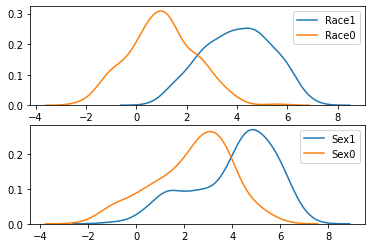

In [109]:
fit = samples.copy()
fit["mean"] = linear_reg_model(x_data).detach().numpy()

S1 = fit[fit["S"] == 1]
S0 = fit[fit["S"] == 0]
R1 = fit[fit["R"] == 1]
R0 = fit[fit["R"] == 0]

#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
f, (ax1, ax2) = plt.subplots(2)

sns.kdeplot(R1["mean"], ax=ax1,label='Race = 1')
sns.kdeplot(R0["mean"], ax=ax1,label='Race = 0')
sns.kdeplot(S1["mean"], ax=ax2,label='Sex = 1')
sns.kdeplot(S0["mean"], ax=ax2,label='Sex = 0')

We can see above that we are getting different density plots when separated out by the protected attributes which as mentioned means that this is not a counterfactually fair algorithim

## Full Model

This model uses all the available observed variables in the model. We can later use this model
to more accurately reconstruct FYA(F) as it uses race and sex. The paper notes that because it
uses all the observed variables, this model achieves the highest accuracy, however it clearly is
biased since it uses protected attributes race and sex directly in its decision making. The
resulting density plots look similar to the unaware model as the full model is still making biased
decisions, but much more openly in its training.

In [110]:
samples = pd.DataFrame(columns=['R', 'S', 'K', 'G', 'L', 'F', 'p'])
full_sample= []
for i in range(1000):
    trace = trace_handler.get_trace()
    R = trace.nodes['R']['value']
    S = trace.nodes['S']['value']
    K = trace.nodes['K']['value']
    G = trace.nodes['G']['value']
    L = trace.nodes['L']['value']
    F = trace.nodes['F']['value']
    # get prob of each combination
    log_prob = trace.log_prob_sum()
    p = np.exp(log_prob)
    samples=samples.append({'R': R, 'S': S, 'K': K, 'G': G, 'L':L, 'F': F, 'p': p}, ignore_index=True)
    full_sample.append(([R,S,G,L,F]))

samples.head()

,R,S,K,G,L,F,p
0,tensor(1.),tensor(1.),tensor(-0.2148),tensor(5.3011),tensor(6.2191),tensor(4.7810),tensor(7.3578)
1,tensor(1.),tensor(1.),tensor(-1.8349),tensor(3.4436),tensor(4.6694),tensor(3.2975),tensor(0.0631)
2,tensor(1.),tensor(1.),tensor(0.2222),tensor(5.7799),tensor(6.5458),tensor(5.2448),tensor(1.6143)
3,tensor(1.),tensor(1.),tensor(0.8138),tensor(6.3525),tensor(7.3679),tensor(5.8802),tensor(4.3821)
4,tensor(1.),tensor(1.),tensor(0.5848),tensor(6.1063),tensor(7.0439),tensor(5.5682),tensor(7.0965)


We have similarly built the Linear Regression model to predict FYA(F) using race, sex, GPA
and, LSAT.

In [111]:
#Data to regress
full_sample = torch.tensor(full_sample)
x_data, y_data = full_sample[:, :-1], full_sample[:, -1]

# Regression model
# 2 = in features, 1=out feature
linear_reg_model = PyroModule[nn.Linear](4, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
#    if (j + 1) % 10 == 0:
#        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())
    

Learned parameters:
weight [[-1.0575161   0.5752189   0.929824    0.05809528]]
bias [-0.00880599]


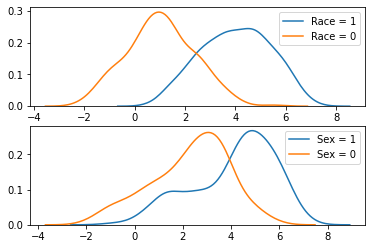

In [112]:
fit = samples.copy()
fit["mean"] = linear_reg_model(x_data).detach().numpy()

S1 = fit[fit["S"] == 1]
S0 = fit[fit["S"] == 0]
R1 = fit[fit["R"] == 1]
R0 = fit[fit["R"] == 0]

f, (ax1, ax2) = plt.subplots(2)

#plot Densities by race and sex
sns.kdeplot(R1["mean"], ax=ax1, label='Race = 1')
sns.kdeplot(R0["mean"], ax=ax1, label='Race = 0')
sns.kdeplot(S1["mean"], ax=ax2, label='Sex = 1')
sns.kdeplot(S0["mean"], ax=ax2, label='Sex = 0')

Once again we see that the density plots, when separated out by the protected attributes are non-overlapping

## Inferring K

In this model, we infer K(as it is unobserved) and use that to predict FYA(F) instead of relying
on the protected attributes race(R) and sex(S) which are parents of GPA(G) and LSAT(L). To
achieve this, we have first trained on all features including race and sex and then infer
Knowledge(K) which is later used to predict FYA(F). While the model’s accuracy is not as high
as the other models, looking at the density plots this model is not biased against race and sex.

In [113]:
samples = pd.DataFrame(columns=['R', 'S', 'K', 'G', 'L', 'F', 'p'])
aware_sample= []
for i in range(1000):
    trace = trace_handler.get_trace()
    R = trace.nodes['R']['value']
    S = trace.nodes['S']['value']
    K = trace.nodes['K']['value']
    G = trace.nodes['G']['value']
    L = trace.nodes['L']['value']
    F = trace.nodes['F']['value']
    # get prob of each combination
    #log_prob = trace.log_prob_sum()
    #p = np.exp(log_prob)
    samples = samples.append({'R': R, 'S': S, 'K': K, 'G': G, 'L':L, 'F': F}, ignore_index=True)
    aware_sample.append(([R,S,F]))

samples.head()

,R,S,K,G,L,F,p
0,tensor(1.),tensor(0.),tensor(-1.4274),tensor(2.4294),tensor(4.5212),tensor(1.5394),NaN
1,tensor(0.),tensor(1.),tensor(0.1284),tensor(1.6254),tensor(0.6364),tensor(2.0925),NaN
2,tensor(1.),tensor(0.),tensor(-0.2036),tensor(3.6938),tensor(6.0384),tensor(2.9031),NaN
3,tensor(1.),tensor(0.),tensor(0.7527),tensor(4.8110),tensor(6.6845),tensor(3.9012),NaN
4,tensor(1.),tensor(0.),tensor(-0.8414),tensor(3.1169),tensor(5.1860),tensor(2.0114),NaN


In [114]:
# assign the observed G and L
G=samples.G
L=samples.L

Iterating through the generated samples to use the observed variables GPA and LSAT to infer
samples for knowledge(K)

In [115]:
# hold all K values
K=[]
# iterate through the 1000 samples of G/L and infer K
for i in range(1000):
        conditioned = pyro.condition(GroundTruthModel, data={"G": G[i], "L": L[i]})

        # use pyro.infer.Importance
        posterior = pyro.infer.Importance(conditioned, num_samples=10).run()
        post_marginal = pyro.infer.EmpiricalMarginal(posterior, "K")
        post_samples = [post_marginal().item() for _ in range(10)]
        post_unique, post_counts = np.unique(post_samples, return_counts=True)
        # calculate the mean of the inferred
        mean = np.mean(post_samples)
        K.append(mean)

Distribution of the Inferred K and the generated K samples 

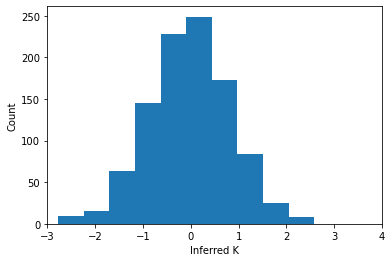

In [116]:
plt.hist(K)
plt.xlim([-3, 4])
plt.ylabel("Count")
plt.xlabel("Inferred K")
plt.show()

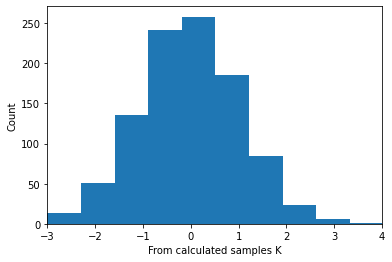

In [117]:
plt.xlim([-3, 4])
plt.hist([float(a) for a in samples.K])
plt.ylabel("Count")
plt.xlabel("From calculated samples K")
plt.show()

Comparison between some of the rows: 

You can see how closely the inferred K's managed to be to the "actual" K's (which we technically can never know).

In [118]:
for i in range(5, 15, 3):
    print(samples.G[i], samples.L[i], samples.K[i], K[i])

tensor(4.8878) tensor(6.6825) tensor(0.6217) 0.5149993896484375
tensor(-0.9373) tensor(-0.7439) tensor(-0.7648) -0.7824064493179321
tensor(-1.9506) tensor(-1.8776) tensor(-1.8266) -0.6514434218406677
tensor(5.9514) tensor(6.7783) tensor(0.3586) 0.24780139327049255


Now use our new inferred K into the Linear Reg Model to predict F

In [119]:
#Data to regress
# convert numpy.float64 types to float, then to tensor (x_data = Infered K values, Y_data = FYA values)
x_data, y_data = torch.tensor(np.array(K).tolist()), torch.tensor(samples.F)
x_data=x_data.resize_(1000,1)

# Regression model
linear_reg_model = PyroModule[nn.Linear](1, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 500 

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
#    if (j + 1) % 10 == 0:
#        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

Learned parameters:
weight [[0.9040322]]
bias [3.294763]


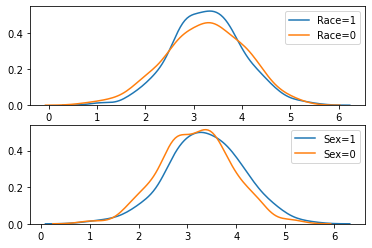

In [120]:
fit = samples.copy()
fit["mean"] = linear_reg_model(x_data).detach().numpy()

S1 = fit[fit["S"] == 1]
S0 = fit[fit["S"] == 0]
R1 = fit[fit["R"] == 1]
R0 = fit[fit["R"] == 0]

f, (ax1, ax2) = plt.subplots(2)
sns.kdeplot(R1["mean"], ax=ax1,label='Race=1')
sns.kdeplot(R0["mean"], ax=ax1,label='Race=0')
sns.kdeplot(S1["mean"], ax=ax2,label='Sex=1')
sns.kdeplot(S0["mean"], ax=ax2,label='Sex=0')

As we see from the above density plots, the predicitions separated out by the protected attributes Race and Sex are overlapping. This is expected under the counterfactual fairness algorithim created by the authors. Inferring the Latent variable K which is not a child of the protected attributes allowed us to make predictions that are counterfactually fair.

## Conculsions: 

After the previous implementation of the counterfactual fairness, we take the protected attributes
into consideration, so we are able to take into account the different social biases that may arise
towards individuals based on ethically sensitive attributes and compensate for these biases
effectively. We share the authors beliefs that fairness should be regulated by explicitly modeling the causal structure of the world. Simply relying on probabilistic independence cannot meet the fair standard, it also cannot point out why and how unfairness is occurring. By implementing the previous counterfactual fairness models, we are able to provide practical solutions for solving a wide array of fairness modeling problems.